In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from fastprogress.fastprogress import progress_bar
import time
from IPython.display import Image

import catboost
from catboost import CatBoostClassifier, Pool

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.viz import plot_uplift_preds, plot_qini_curve
from sklift.metrics.metrics import qini_auc_score

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import os

In [2]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [11]:
RANDOM_SEED = 42
#INPUT_DIR_PATH = 'gdrive/My Drive/Colab Notebooks/Uplift modeling/Megafon_competition/' #For Google Collabratory
INPUT_DIR_PATH = ''

# graphiz settings
os.environ["PATH"] += os.pathsep + 'C:\\Users\\ahmad\\Anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz'

In [47]:
def optimize_memory(df):
    if isinstance(df, pd.DataFrame):
        for col in df.columns:
            if df[col].dtype in [np.float64, np.float32, np.float16]:
                df[col] = pd.to_numeric(df[col], downcast='float')
            elif df[col].dtype in [np.int64, np.int32, np.int16]:
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif df[col].dtype == object:
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if num_unique_values / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
    else:
        print('df must be a pandas dataframe')
        
    return df


def show_qini_score(prediction, y, treatment):
    return 'qini score ' + str(qini_auc_score(y, prediction, treatment))

In [5]:
train = pd.read_csv(INPUT_DIR_PATH+'data/train.csv')
train = optimize_memory(train)
train.sample(5)

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
255337,255337,control,-37.630054,-0.966872,31.962681,-97.057083,-44.052174,-119.801048,-2.696063,-122.642967,...,52.347115,-43.386101,1.882492,18.765146,-1.293656,-796.769592,-189.269043,-135.890747,-31.096663,0
182004,182004,treatment,-14.328455,0.213952,12.891713,19.688610,-44.749046,-160.683960,-27.705889,24.756128,...,-106.761665,-421.278259,-0.832805,-73.902237,0.591550,-18.761770,343.663147,130.045197,-3.262093,0
56874,56874,treatment,-56.268032,0.690961,-25.115206,-62.575565,63.537174,-46.056732,82.326920,39.050838,...,-101.830460,184.328323,0.703553,31.171799,-0.068902,222.121323,-25.820681,56.902718,-29.774015,0
40160,40160,treatment,-39.877602,0.590418,-52.423599,44.360210,19.863600,132.124741,-21.807102,79.200493,...,9.132356,611.894043,-2.187140,154.292191,-0.252401,459.158356,-223.939438,26.872850,11.874783,1
86054,86054,treatment,-39.169449,-0.178589,73.584991,18.811596,27.385077,45.385151,18.211021,-29.124090,...,-43.404373,-512.106384,0.311571,20.551706,0.408499,-721.982422,167.964890,61.788666,-24.599577,0


In [6]:
test = pd.read_csv(INPUT_DIR_PATH+'data/test.csv')
test = optimize_memory(test)
test.sample(5)

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
285149,285149,control,1.084497,-0.068559,-14.568756,-53.956806,69.879074,-98.441956,6.361098,34.533661,...,-76.813713,-66.524055,-163.822479,-0.236826,26.860390,-0.711438,-206.417938,-2.068983,26.381870,-40.906654
539900,539900,control,-66.524803,0.189094,27.768431,1.508603,41.535934,-61.101307,97.235703,-30.514542,...,-123.577614,-83.792061,-106.537102,-0.274347,-4.797853,-1.986211,-1444.040405,-286.679657,90.559242,-3.453791
257969,257969,control,48.445221,-0.623589,15.793602,7.797205,-68.928505,141.493347,-13.070436,-72.379433,...,-12.672492,-36.946354,-249.557312,-0.382119,9.236544,-0.001308,-1143.350098,-177.629486,45.815704,0.604716
594435,594435,control,-9.606915,1.001952,26.839209,68.401955,3.875614,-20.470024,53.824051,51.372387,...,117.296562,-182.509171,-37.427448,0.490174,-73.077187,2.776562,372.916382,126.005325,250.984146,4.511525
253990,253990,control,18.868902,0.833877,7.430661,-33.167744,68.178474,79.053856,137.820312,9.202328,...,383.381744,15.783331,976.038330,-1.205615,-116.785194,-0.790281,-14.161861,-117.453850,-44.194302,-1.351879


# Preprocessing (sklift models)

In [37]:
X = train.drop(['id', 'conversion'], axis=1)
X['treatment_group'] = X['treatment_group'].map({'treatment':1, 'control':0}).astype(float)
y = train['conversion'].copy()
treatment = X['treatment_group'].copy()

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

treatment_train = X_train['treatment_group'].copy()
treatment_val = X_val['treatment_group'].copy()

X_train.drop(['treatment_group'], inplace=True, axis=1)
X_val.drop(['treatment_group'], inplace=True, axis=1)

X_test = test.drop(['id', 'treatment_group'], axis=1) 

X.drop(['treatment_group'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Feature engineering

## PCA

In [9]:
qini_scores_train = []
qini_scores_val = []

for n_comp in  progress_bar(range(10, 50, 10)): 
    treatment_model = CatBoostClassifier(silent=True, random_seed=RANDOM_SEED)
    control_model = CatBoostClassifier(silent=True, random_seed=RANDOM_SEED)
    two_models = TwoModels(treatment_model, control_model)

    pca_transformer = PCA(n_components=n_comp)
    X_train_pca = pca_transformer.fit_transform(X_train)
    X_val_pca = pca_transformer.transform(X_val)

    two_models.fit(X_train_pca, treatment_train, y_train)
    qini_scores_train.append(qini_auc_score(y_train, two_models.predict(X_train_pca), treatment_train))
    qini_scores_val.append(qini_auc_score(y_val, two_models.predict(X_val_pca), treatment_val))

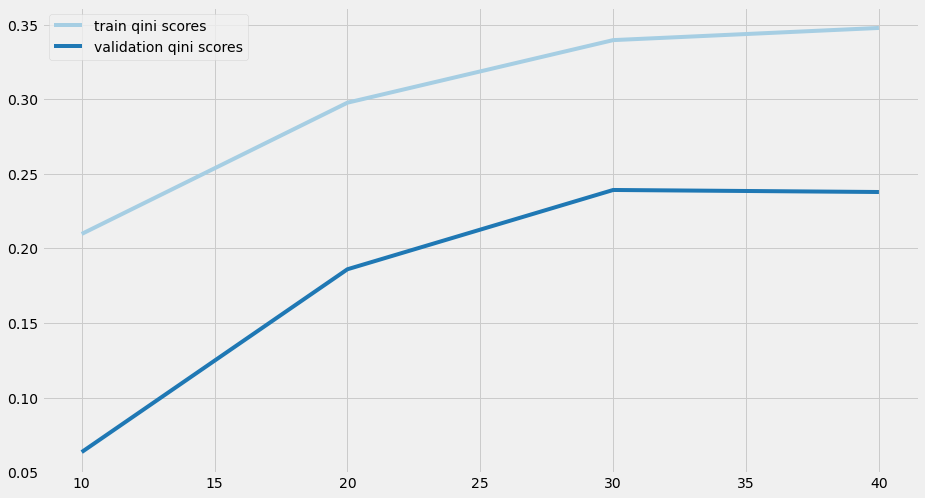

In [10]:
fig = plt.figure(figsize=(14, 8))
plt.plot(np.arange(10, 50, 10), qini_scores_train, label='train qini scores')
plt.plot(np.arange(10, 50, 10), qini_scores_val, label='validation qini scores')
plt.legend()
plt.show()

# Preprocessing (causalml models)

In [27]:
X = train.drop(['id', 'conversion'], axis=1)
y = train['conversion'].copy()
treatment = X['treatment_group'].copy()

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

treatment_train = X_train['treatment_group'].copy()
treatment_val = X_val['treatment_group'].copy()

X_train.drop(['treatment_group'], inplace=True, axis=1)
X_val.drop(['treatment_group'], inplace=True, axis=1)

X_test = test.drop(['id', 'treatment_group'], axis=1) 

X.drop(['treatment_group'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
uplift_model = UpliftTreeClassifier(control_name='control')
uplift_model.fit(X_train.values, treatment_train.values, y_train.values)

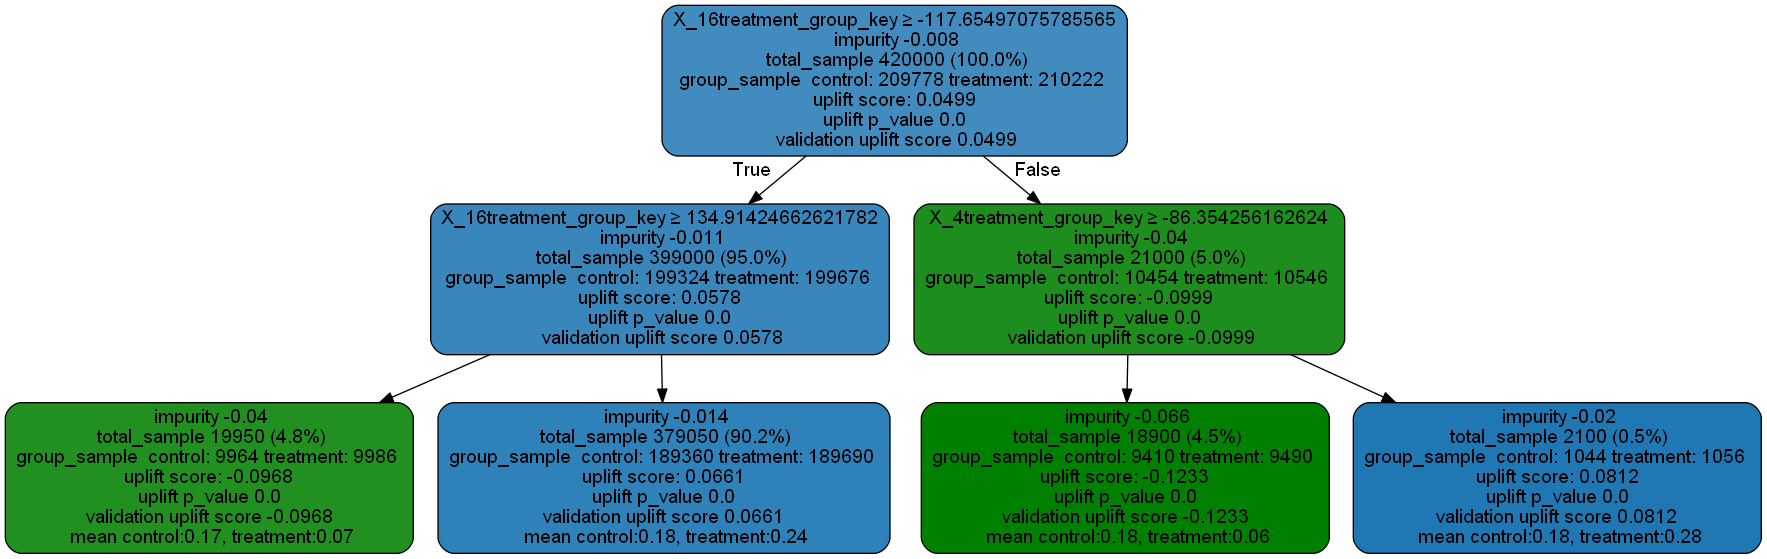

In [34]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_train.columns)
Image(graph.create_png(), width=2000, height=4000)

## KBins

In [39]:
%%time

selected_features = ['X_16', 'X_4', 'X_29', 'X_8', 'X_35']
new_features = [feature+'_new' for feature in selected_features]

strategy_list = ['uniform', 'quantile', 'kmeans']

for strategy in strategy_list:
    kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=strategy)
    
    X_train_temp = X_train.copy()

    X_train_temp[new_features] = kbins_transformer.fit_transform(X_train_temp[selected_features])
    X_train_temp = optimize_memory(X_train_temp)
    
    control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
    treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)

    two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
    two_models.fit(X_train_temp, y_train, treatment_train)
    
    del X_train_temp
    X_val_temp = X_val.copy()
    X_val_temp[new_features] = kbins_transformer.transform(X_val_temp[selected_features])
    
    pred = two_models.predict(X_val_temp)
    del X_val_temp
    print('qini score', qini_auc_score(y_val, pred, treatment_val))

qini score 0.24337079426491515
qini score 0.24036438000585097
qini score 0.24091881242912608
Wall time: 9min 5s


## Generate kbins on catboost first tree

In [40]:
%%time

control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)

two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
two_models.fit(X_train, y_train, treatment_train)

Wall time: 2min 56s


TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x0000029A0E155688>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x0000029A0E155CC8>,
          method='vanilla')

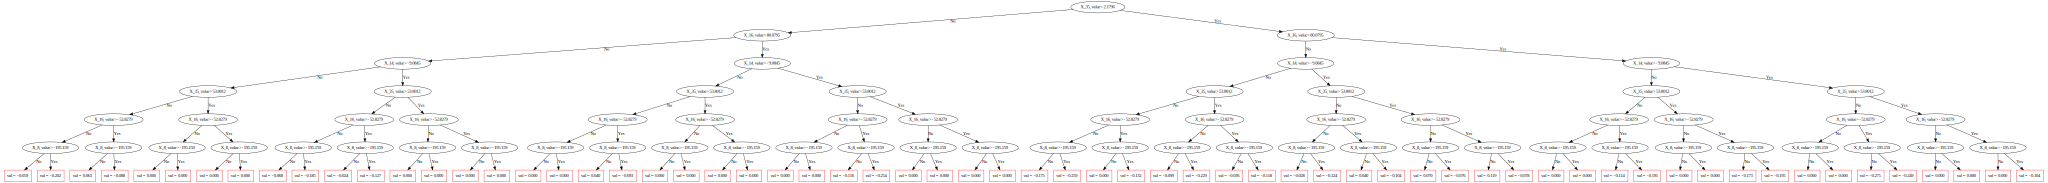

In [41]:
train_pool = Pool(X_train, y_train)
treatment_model.plot_tree(pool=train_pool, tree_idx=0)

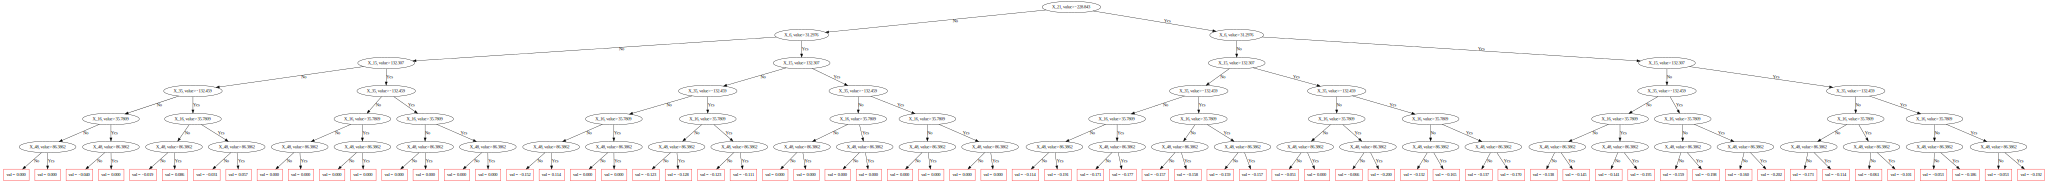

In [42]:
control_model.plot_tree(pool=train_pool, tree_idx=0)

In [43]:
%%time

selected_features = ['X_35', 'X_16', 'X_14', 'X_21', 'X_6', 'X_15' ]
new_features = [feature+'_new' for feature in selected_features]

strategy_list = ['uniform', 'quantile', 'kmeans']

for strategy in strategy_list:
    kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=strategy)
    
    X_train_temp = X_train.copy()

    X_train_temp[new_features] = kbins_transformer.fit_transform(X_train_temp[selected_features])
    X_train_temp = optimize_memory(X_train_temp)
    
    control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
    treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)

    two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
    two_models.fit(X_train_temp, y_train, treatment_train)
    
    del X_train_temp
    X_val_temp = X_val.copy()
    X_val_temp[new_features] = kbins_transformer.transform(X_val_temp[selected_features])
    
    pred = two_models.predict(X_val_temp)
    del X_val_temp
    print(str(strategy), 'qini score', qini_auc_score(y_val, pred, treatment_val))

uniform qini score 0.23905068559268208
quantile qini score 0.24177142611061717
kmeans qini score 0.24077088971614188
Wall time: 9min 20s


## Conversion feature

In [44]:
temp_df = pd.concat([y_train, treatment_train], axis=1)

temp_df = temp_df.groupby('treatment_group').conversion.agg(
    cnt = 'count',
    conv = 'sum'
).reset_index()

temp_df['res_conversion'] = temp_df['conv']/temp_df['cnt']
temp_df.drop(['cnt', 'conv'], axis=1, inplace=True)

conv_dict = {0: temp_df['res_conversion'].loc[0], 1:temp_df['res_conversion'].loc[1]}

In [45]:
X_train = pd.concat([X_train, treatment_train], axis=1)
X_val = pd.concat([X_val, treatment_val], axis=1)

X_train['conv_value'] = X_train['treatment_group'].map(conv_dict)
X_val['conv_value'] = X_val['treatment_group'].map(conv_dict)

X_train.drop(['treatment_group'], axis=1, inplace=True)
X_val.drop(['treatment_group'], axis=1, inplace=True)

X_train['conv_value'] = X_train['conv_value'].astype(np.float32)
X_val['conv_value'] = X_val['conv_value'].astype(np.float32)

In [48]:
%%time

control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)

two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
two_models.fit(X_train, y_train, treatment_train)

print(show_qini_score(two_models.predict(X_val), y_val, treatment_val))

qini score 0.24068950884130774
Wall time: 2min 54s


# Feature selection on correlation with uplift
## Add a new features

In [49]:
selected_features = ['X_16', 'X_4', 'X_29', 'X_8', 'X_35']
new_features = [feature+'_new' for feature in selected_features]


kbins_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    
X_train[new_features] = kbins_transformer.fit_transform(X_train[selected_features])
X_train = optimize_memory(X_train)

X_val[new_features] = kbins_transformer.transform(X_val[selected_features])
X_val = optimize_memory(X_val)

## Select

In [50]:
%%time

control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)

two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
two_models.fit(X_train, y_train, treatment_train)

Wall time: 2min 54s


TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x0000029A0755FA08>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x0000029A0755F388>,
          method='vanilla')

In [51]:
X_train['prediction'] = two_models.predict(X_train)

corr_matrix = X_train.corr()
corr_list = np.fabs(corr_matrix['prediction']).sort_values(ascending=False)[1:]
# Let's choose only 10, 20, 30, 40, 50 features with max correlation with uplift 

In [52]:
for num_features in progress_bar(range(10, 60, 10)):
    control_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
    treatment_model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
    
    feature_list = corr_list.index[:num_features]

    two_models = TwoModels(estimator_ctrl=control_model, estimator_trmnt=treatment_model, method='vanilla')
    two_models.fit(X_train[feature_list], y_train, treatment_train)
    pred = two_models.predict(X_val[feature_list])
    print('num features', num_features, 'qini score', qini_auc_score(y_val, pred, treatment_val))

num features 10 qini score 0.10261495446222524
num features 20 qini score 0.14663742301053265
num features 30 qini score 0.17327374604444218
num features 40 qini score 0.21517612851828324
num features 50 qini score 0.2294835503502309
